# Comprehensive fMRI Reconstruction Evaluation

This notebook provides a systematic evaluation framework for fMRI-to-image reconstruction methods using multiple quality metrics.

## Overview

The evaluation system supports:
- Low-level metrics: SSIM, Pixel Correlation
- High-level metrics: AlexNet, CLIP, InceptionV3
- Distance metrics: EfficientNet, SwAV
- Image quality: Inception Score, FID
- Brain correlation: GNet-based correlations
- Retrieval metrics: Image and Brain retrieval

## Configuration

Modify the parameters below to customize your evaluation setup.


## Configuration and Setup


In [1]:
# ===== EVALUATION CONFIGURATION =====
import os
import json
from pathlib import Path
from datetime import datetime

# Paths
PROJECT_ROOT = '/home/kevin/Documents/ACV/Project/advanced-cv-project'
BASE_OUTPUT_DIR = f'{PROJECT_ROOT}/outputs_all/subj01'
GT_DIR = f'{PROJECT_ROOT}/outputs_all/subj01/ground_truth'
FMRI_DIR = f'{PROJECT_ROOT}/MindEyeV2'

# Evaluation parameters
NUM_IMAGES_TO_EVALUATE = 50
BATCH_SIZE = 8
DEVICE = 'cuda'

# Data availability flags
HAS_GROUND_TRUTH = True
HAS_FMRI_DATA = True
HAS_GNET_MODEL = False

# Results storage
RESULTS_FILE = f'{PROJECT_ROOT}/evaluation_results.json'

print(f"Base output directory: {BASE_OUTPUT_DIR}")
print(f"Ground truth directory: {GT_DIR}")
print(f"fMRI data directory: {FMRI_DIR}")
print(f"Images to evaluate: {NUM_IMAGES_TO_EVALUATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Device: {DEVICE}")
print(f"Has ground truth: {HAS_GROUND_TRUTH}")
print(f"Has fMRI data: {HAS_FMRI_DATA}")
print(f"Has GNet model: {HAS_GNET_MODEL}")
print(f"Results will be saved to: {RESULTS_FILE}")


Base output directory: /home/kevin/Documents/ACV/Project/advanced-cv-project/outputs_all/subj01
Ground truth directory: /home/kevin/Documents/ACV/Project/advanced-cv-project/outputs_all/subj01/ground_truth
fMRI data directory: /home/kevin/Documents/ACV/Project/advanced-cv-project/MindEyeV2
Images to evaluate: 50
Batch size: 8
Device: cuda
Has ground truth: True
Has fMRI data: True
Has GNet model: False
Results will be saved to: /home/kevin/Documents/ACV/Project/advanced-cv-project/evaluation_results.json


## Experimental Directory Discovery


In [2]:
# ===== FIND EXPERIMENTAL DIRECTORIES =====
def find_experimental_dirs(base_dir):
    """
    Find all experimental directories with timestamp subdirectories
    """
    experimental_dirs = []
    base_path = Path(base_dir)
    
    if not base_path.exists():
        print(f"Base directory not found: {base_dir}")
        return experimental_dirs
    
    # Look for nested timestamp directories in the structure:
    # cp_4096_v1_with_z/{guidance_scale}/{guidance_strength}/{timestamp}
    # cp_4096_v1_no_z/{guidance_scale}/{guidance_strength}/{timestamp}
    # brain_scheduling/{guidance_scale}/{guidance_strength}/{timestamp}
    
    for method_dir in base_path.iterdir():
        if method_dir.is_dir() and (method_dir.name.startswith('cp_4096_v1') or method_dir.name == 'brain_scheduling'):
            print(f"Scanning method directory: {method_dir.name}")
            
            for guidance_scale_dir in method_dir.iterdir():
                if guidance_scale_dir.is_dir() and guidance_scale_dir.name.isdigit():
                    print(f"  Scanning guidance scale: {guidance_scale_dir.name}")
                    
                    for guidance_strength_dir in guidance_scale_dir.iterdir():
                        if guidance_strength_dir.is_dir():
                            print(f"    Scanning guidance strength: {guidance_strength_dir.name}")
                            
                            for timestamp_dir in guidance_strength_dir.iterdir():
                                if timestamp_dir.is_dir() and len(timestamp_dir.name) == 15 and timestamp_dir.name[8] == '_':
                                    experimental_dirs.append(timestamp_dir)
                                    print(f"      Found experiment: {timestamp_dir}")
    
    return experimental_dirs

# Find all experimental directories
experimental_dirs = find_experimental_dirs(BASE_OUTPUT_DIR)
print(f"\nFound {len(experimental_dirs)} experimental directories:")
for i, exp_dir in enumerate(experimental_dirs):
    print(f"  {i+1}. {exp_dir}")

# Load existing results with error handling
def load_existing_results_safe(filename):
    """Load existing results with proper error handling"""
    if not os.path.exists(filename):
        print(f"\nNo existing results file found, starting fresh")
        return {}
    
    try:
        with open(filename, 'r') as f:
            results = json.load(f)
        print(f"\nLoaded existing results with {len(results)} experiments")
        return results
    except (json.JSONDecodeError, ValueError) as e:
        print(f"\nError loading existing results file: {e}")
        print(f"File may be corrupted. Starting fresh...")
        # Optionally backup the corrupted file
        backup_file = filename + ".corrupted"
        try:
            import shutil
            shutil.move(filename, backup_file)
            print(f"Corrupted file backed up to: {backup_file}")
        except Exception as backup_error:
            print(f"Could not backup corrupted file: {backup_error}")
        return {}
    except Exception as e:
        print(f"\nUnexpected error loading results: {e}")
        return {}

# Load existing results with error handling
all_results = load_existing_results_safe(RESULTS_FILE)

Scanning method directory: brain_scheduling
  Scanning guidance scale: 100000
    Scanning guidance strength: 0.4
      Found experiment: /home/kevin/Documents/ACV/Project/advanced-cv-project/outputs_all/subj01/brain_scheduling/100000/0.4/20251027_192430
    Scanning guidance strength: 0.2
      Found experiment: /home/kevin/Documents/ACV/Project/advanced-cv-project/outputs_all/subj01/brain_scheduling/100000/0.2/20251026_215211
    Scanning guidance strength: 0.1
      Found experiment: /home/kevin/Documents/ACV/Project/advanced-cv-project/outputs_all/subj01/brain_scheduling/100000/0.1/20251027_200225
  Scanning guidance scale: 30000
    Scanning guidance strength: 0.4
      Found experiment: /home/kevin/Documents/ACV/Project/advanced-cv-project/outputs_all/subj01/brain_scheduling/30000/0.4/20251027_181755
    Scanning guidance strength: 0.2
      Found experiment: /home/kevin/Documents/ACV/Project/advanced-cv-project/outputs_all/subj01/brain_scheduling/30000/0.2/20251026_212457
    Sc

## Import Required Libraries

In [3]:
# ===== IMPORT LIBRARIES =====
import os 
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add project to path
import sys
sys.path.insert(0, PROJECT_ROOT)

# Check GPU availability
device = torch.device(DEVICE if torch.cuda.is_available() and DEVICE == 'cuda' else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Using device: cuda
GPU: NVIDIA GeForce RTX 5070 Ti
Memory: 16.60 GB


## Initialize Evaluation Metrics

In [4]:
# ===== INITIALIZE EVALUATION METRICS =====
from evaluation.orchestrator import EvaluationOrchestrator
from evaluation.low_level import SSIM, PixCorr
from evaluation.high_level import AlexNetMetrics, CLIPMetrics, InceptionMetrics
from evaluation.distance import EfficientNetDistance, SwAVDistance
from evaluation.brain_correlation import BrainCorrelationMetrics
from evaluation.retrieval import ImageRetrieval, BrainRetrieval
from evaluation.image_quality import InceptionScore, FID

# Initialize evaluation orchestrator
evaluator = EvaluationOrchestrator(device=device)
print("Evaluation orchestrator initialized!")

# Initialize individual metrics for testing
print("\nInitializing individual metrics...")

# High-level metrics
alexnet_metrics = AlexNetMetrics(device=device)
inception_metrics = InceptionMetrics(device=device)
print("AlexNet and InceptionV3 metrics ready")

# Distance metrics
effnet_dist = EfficientNetDistance(device=device)
print("EfficientNet distance ready")

# Image quality metrics
is_metric = InceptionScore(device=device)
fid_metric = FID(device=device)
print("Image quality metrics (IS, FID) ready")

# Low-level metrics (if ground truth available)
if HAS_GROUND_TRUTH:
    ssim_metric = SSIM(device=device)
    pixcorr_metric = PixCorr(device=device)
    print("Low-level metrics (SSIM, PixCorr) ready")

# Brain correlation metrics (if fMRI data available)
if HAS_FMRI_DATA:
    brain_corr = BrainCorrelationMetrics(device=device)
    print("Brain correlation metrics ready")

print("\nAll available metrics initialized successfully!")


Using cache found in /home/kevin/.cache/torch/hub/facebookresearch_swav_main


SwAV model loaded successfully
Evaluation orchestrator initialized!

Initializing individual metrics...
AlexNet and InceptionV3 metrics ready
EfficientNet distance ready
Image quality metrics (IS, FID) ready
Low-level metrics (SSIM, PixCorr) ready
Brain correlation metrics ready

All available metrics initialized successfully!


## Ground Truth Image Loading


In [5]:
def load_ground_truth_images_corrected():
    """Load and preprocess ground truth images exactly like original test_orchestrator.py"""
    if not HAS_GROUND_TRUTH:
        print("Ground truth not available, skipping...")
        return None
    
    # Load and preprocess ground truth images (exactly like original)
    from torchvision import transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    # Load 50 ground truth images (like original) - in numerical order 0-49
    gt_tensors = []
    for i in tqdm(range(50), desc="Loading ground truth"):
        gt_path = os.path.join(GT_DIR, f"{i:05d}.png")
        gt_img = Image.open(gt_path)
        gt_tensor = transform(gt_img)
        gt_tensors.append(gt_tensor)
    
    gt_batch = torch.stack(gt_tensors, dim=0).to(device)
    print(f"GT batch shape: {gt_batch.shape}")
    return gt_batch

## Image Loading Functions


SSIM vs Guidance Scale plot (str=0.4) saved to: /home/kevin/Documents/ACV/Project/advanced-cv-project/ssim_vs_guidance_scale_str02.png


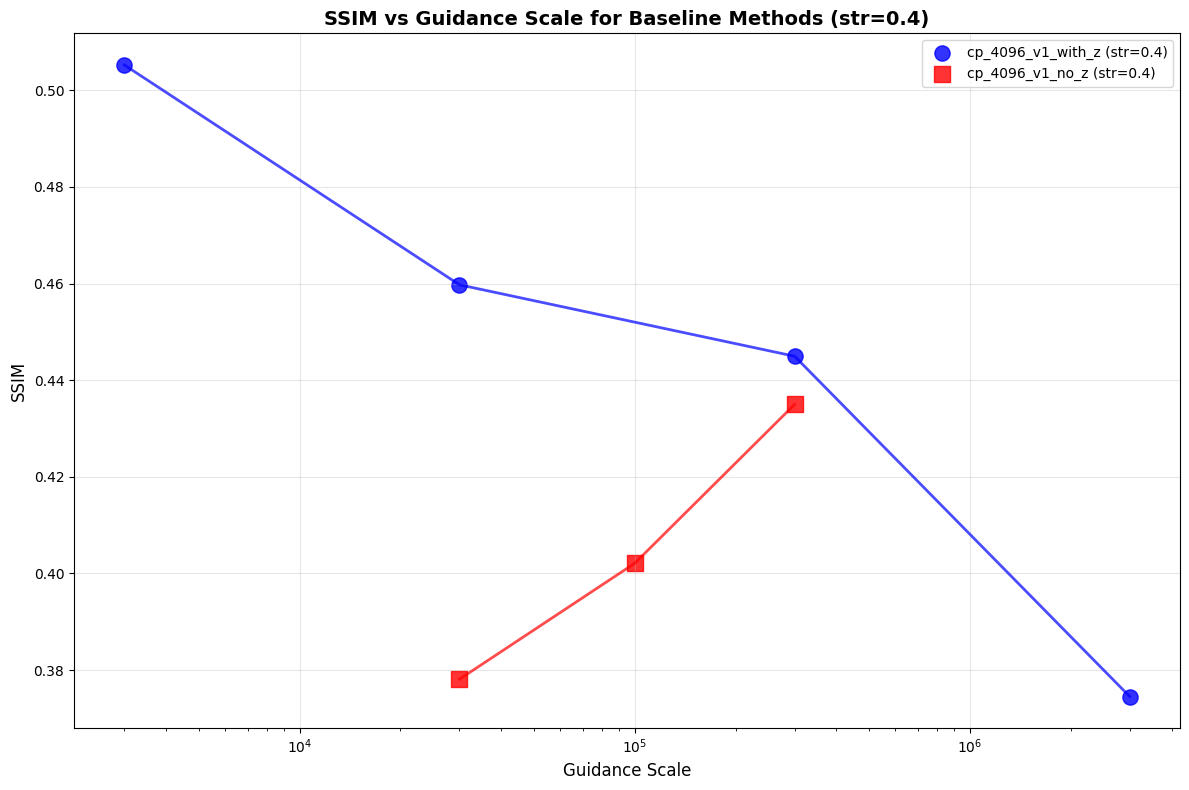


SSIM vs GUIDANCE SCALE SUMMARY (str=0.4)

cp_4096_v1_with_z:
  Guidance scales tested: [np.float64(3000.0), np.float64(30000.0), np.float64(300000.0), np.float64(3000000.0)]
  SSIM range: 0.3745 - 0.5053
  Best SSIM: 0.5053 at scale 3000.0
  Peak performance: SSIM=0.5053 at guidance_scale=3000.0

cp_4096_v1_no_z:
  Guidance scales tested: [np.float64(30000.0), np.float64(100000.0), np.float64(300000.0)]
  SSIM range: 0.3781 - 0.4350
  Best SSIM: 0.4350 at scale 300000.0
  Peak performance: SSIM=0.4350 at guidance_scale=300000.0


In [18]:
# ===== SSIM vs GUIDANCE SCALE ANALYSIS (str=0.4 only) =====
import matplotlib.pyplot as plt
import numpy as np

def plot_ssim_vs_guidance_scale(results_dict):
    """Plot SSIM vs Guidance Scale for baseline methods (str=0.4 only)"""
    if not results_dict:
        print("No results to plot!")
        return
    
    # Filter for baseline methods only
    baseline_methods = ['cp_4096_v1_with_z', 'cp_4096_v1_no_z']
    
    # Extract data for plotting
    plot_data = {}
    
    for exp_name, results in results_dict.items():
        method = results.get('method_name', '')
        guidance_scale = results.get('guidance_scale', '')
        guidance_strength = results.get('guidance_strength', '')
        ssim = results.get('low_level', {}).get('SSIM', {}).get('mean', 0)
        
        # Only include baseline methods with str=0.4
        if (method in baseline_methods and 
            guidance_scale and 
            ssim > 0 and 
            float(guidance_strength) == 0.4):
            
            # Convert guidance scale to float
            try:
                scale_val = float(guidance_scale)
                
                if method not in plot_data:
                    plot_data[method] = {'scales': [], 'ssim': []}
                
                plot_data[method]['scales'].append(scale_val)
                plot_data[method]['ssim'].append(ssim)
                
            except ValueError:
                continue
    
    if not plot_data:
        print("No baseline method data found for plotting!")
        return
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    colors = {'cp_4096_v1_with_z': 'blue', 'cp_4096_v1_no_z': 'red'}
    markers = {'cp_4096_v1_with_z': 'o', 'cp_4096_v1_no_z': 's'}
    
    for method, data in plot_data.items():
        if not data['scales']:
            continue
            
        # Sort by guidance scale for proper curve
        sorted_indices = np.argsort(data['scales'])
        scales = np.array(data['scales'])[sorted_indices]
        ssim_values = np.array(data['ssim'])[sorted_indices]
        
        # Plot points and connecting line
        plt.scatter(scales, ssim_values, 
                   color=colors[method], 
                   marker=markers[method],
                   s=120, alpha=0.8,
                   label=f'{method} (str=0.4)')
        
        # Draw line connecting points for each method
        plt.plot(scales, ssim_values, color=colors[method], 
                linestyle='-', alpha=0.7, linewidth=2)
    
    plt.xlabel('Guidance Scale', fontsize=12)
    plt.ylabel('SSIM', fontsize=12)
    plt.title('SSIM vs Guidance Scale for Baseline Methods (str=0.4)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Set x-axis to log scale for better visualization
    plt.xscale('log')
    
    # Add some padding
    plt.tight_layout()
    
    # Save the plot
    plot_file = f'{PROJECT_ROOT}/ssim_vs_guidance_scale_str02.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"SSIM vs Guidance Scale plot (str=0.4) saved to: {plot_file}")
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SSIM vs GUIDANCE SCALE SUMMARY (str=0.4)")
    print("="*60)
    
    for method, data in plot_data.items():
        if not data['scales']:
            continue
            
        scales = np.array(data['scales'])
        ssim_values = np.array(data['ssim'])
        
        print(f"\n{method}:")
        print(f"  Guidance scales tested: {sorted(scales)}")
        print(f"  SSIM range: {ssim_values.min():.4f} - {ssim_values.max():.4f}")
        print(f"  Best SSIM: {ssim_values.max():.4f} at scale {scales[np.argmax(ssim_values)]}")
        
        # Find peak guidance scale
        peak_idx = np.argmax(ssim_values)
        peak_scale = scales[peak_idx]
        peak_ssim = ssim_values[peak_idx]
        
        print(f"  Peak performance: SSIM={peak_ssim:.4f} at guidance_scale={peak_scale}")

# Create the SSIM vs Guidance Scale plot
plot_ssim_vs_guidance_scale(all_results)

In [6]:
def load_reconstruction_images(exp_dir, max_images=None):
    """Load reconstruction images exactly like original test_orchestrator.py"""
    if max_images is None:
        max_images = 50  # Load 50 concatenated images (each contains 5 reconstructions)
    
    # Load and preprocess images (exactly like original)
    from torchvision import transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    recon_tensors = []
    
    # Load reconstruction images (exactly like original)
    for i in range(max_images):  # Load 50 concatenated images
        recon_path = os.path.join(exp_dir, f"{i:05d}.png")
        recon_img = Image.open(recon_path)
        
        if recon_img.size == (2560, 512):  # Concatenated
            # Split into 5 individual reconstructions
            for j in range(5):
                left = j * 512
                right = (j + 1) * 512
                individual_img = recon_img.crop((left, 0, right, 512))
                individual_img = individual_img.resize((224, 224), Image.Resampling.LANCZOS)
                tensor = transform(individual_img)
                recon_tensors.append(tensor)
    
    recon_batch = torch.stack(recon_tensors, dim=0).to(device)
    print(f"Recon batch shape: {recon_batch.shape}")
    return recon_batch

## Single Experiment Evaluation


In [7]:
# ===== SINGLE EXPERIMENT EVALUATION =====
def evaluate_single_experiment(exp_dir, exp_name):
    """Evaluate a single experimental directory with 5 reconstructions per ground truth"""
    print(f"\n{'='*60}")
    print(f"EVALUATING: {exp_name}")
    print(f"Directory: {exp_dir}")
    print(f"{'='*60}")
    
    # Load ground truth images first
    gt_batch = load_ground_truth_images_corrected()
    if gt_batch is None:
        print("No ground truth available, skipping evaluation")
        return None
    
    # Load reconstruction images
    recon_batch = load_reconstruction_images(exp_dir)
    if recon_batch is None:
        return None
    
    # Run evaluation
    try:
        print("Running comprehensive evaluation...")
        
        # Handle 5 reconstructions per ground truth image
        if recon_batch.shape[0] == 250 and gt_batch is not None and gt_batch.shape[0] == 50:
            # We have 250 reconstructions and 50 ground truth images
            # This means 5 reconstructions per ground truth image
            print("Detected 5 reconstructions per ground truth image")
            
            # Group reconstructions by ground truth image
            num_gt_images = gt_batch.shape[0]
            reconstructions_per_gt = recon_batch.shape[0] // num_gt_images
            
            print(f"Grouping {reconstructions_per_gt} reconstructions per ground truth image")
            
            # Evaluate each group and select the best
            best_reconstructions = []
            best_scores = []
            
            for gt_idx in range(num_gt_images):
                gt_image = gt_batch[gt_idx:gt_idx+1]  # Shape: [1, 3, 224, 224]
                
                # Get the 5 reconstructions for this ground truth image
                start_idx = gt_idx * reconstructions_per_gt
                end_idx = start_idx + reconstructions_per_gt
                group_reconstructions = recon_batch[start_idx:end_idx]  # Shape: [5, 3, 224, 224]
                
                # Evaluate each reconstruction in this group
                group_scores = []
                for recon_idx in range(reconstructions_per_gt):
                    recon_image = group_reconstructions[recon_idx:recon_idx+1]  # Shape: [1, 3, 224, 224]
                    
                    # Compute SSIM for this reconstruction
                    ssim_val = evaluator.ssim.compute(recon_image, gt_image)
                    group_scores.append(ssim_val)
                
                # Find the best reconstruction for this ground truth image
                best_idx = np.argmax(group_scores)
                best_recon = group_reconstructions[best_idx:best_idx+1]
                best_score = group_scores[best_idx]
                
                best_reconstructions.append(best_recon)
                best_scores.append(best_score)
                
                print(f"  GT {gt_idx}: Best SSIM = {best_score:.4f} (reconstruction {best_idx})")
            
            # Stack the best reconstructions
            best_recon_batch = torch.cat(best_reconstructions, dim=0)
            print(f"Selected best reconstructions: {best_recon_batch.shape}")
            
            # Now evaluate the best reconstructions
            eval_params = {
                'recon_batch': best_recon_batch,
                'gt_batch': gt_batch,
                'actual_fmri': None,  # Add if available
                'region_masks': None,  # Add if available
                'real_images': None   # Add if available
            }
            
            results = evaluator.comprehensive_evaluation(**eval_params)
        
        else:
            # Handle other cases (single reconstructions, etc.)
            print(f"Reconstruction batch shape: {recon_batch.shape}")
            if gt_batch is not None:
                print(f"Ground truth batch shape: {gt_batch.shape}")
            
            eval_params = {
                'recon_batch': recon_batch,
                'gt_batch': gt_batch,
                'actual_fmri': None,
                'region_masks': None,
                'real_images': None
            }
            
            results = evaluator.comprehensive_evaluation(**eval_params)
        
        # Extract experiment metadata from path
        path_parts = exp_dir.parts
        method_name = path_parts[-4]  # cp_4096_v1_with_z, cp_4096_v1_no_z, or brain_scheduling
        guidance_scale = path_parts[-3]  # 3000, 30000, etc.
        guidance_strength = path_parts[-2]  # 0.1, 0.2, 0.4
        timestamp = path_parts[-1]  # 20251026_143307
        
        # Add metadata
        results['experiment_name'] = f"{method_name}_scale{guidance_scale}_str{guidance_strength}_{timestamp}"
        results['experiment_dir'] = str(exp_dir)
        results['method_name'] = method_name
        results['guidance_scale'] = guidance_scale
        results['guidance_strength'] = guidance_strength
        results['timestamp'] = timestamp
        results['evaluation_timestamp'] = datetime.now().isoformat()
        results['num_images'] = recon_batch.shape[0]
        
        return results
        
    except Exception as e:
        print(f"Error evaluating {exp_name}: {e}")
        import traceback
        traceback.print_exc()
        return None

## Results Management Functions


In [8]:
# ===== RESULTS MANAGEMENT FUNCTIONS =====
def save_results(results_dict, filename=None):
    """Save results to JSON file with proper serialization"""
    if filename is None:
        filename = RESULTS_FILE
    
    try:
        # Convert numpy arrays and float32 to JSON-serializable types
        def convert_for_json(obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, np.float32):
                return float(obj)
            elif isinstance(obj, np.float64):
                return float(obj)
            elif isinstance(obj, np.int32):
                return int(obj)
            elif isinstance(obj, np.int64):
                return int(obj)
            elif isinstance(obj, dict):
                return {key: convert_for_json(value) for key, value in obj.items()}
            elif isinstance(obj, list):
                return [convert_for_json(item) for item in obj]
            else:
                return obj
        
        # Convert all numpy types to JSON-serializable types
        serializable_results = convert_for_json(results_dict)
        
        with open(filename, 'w') as f:
            json.dump(serializable_results, f, indent=2)
        print(f"Results saved to: {filename}")
        return True
    except Exception as e:
        print(f"Error saving results: {e}")
        return False

def load_existing_results(filename=None):
    """Load existing results from JSON file"""
    if filename is None:
        filename = RESULTS_FILE
    
    if os.path.exists(filename):
        try:
            with open(filename, 'r') as f:
                return json.load(f)
        except Exception as e:
            print(f"Error loading existing results: {e}")
            return {}
    return {}

## Main Evaluation Loop


In [9]:
# ===== MAIN EVALUATION LOOP =====
def run_evaluation_loop():
    """Run the main evaluation loop"""
    print(f"\nStarting evaluation of {len(experimental_dirs)} experiments...")
    
    # Load existing results
    all_results = load_existing_results()
    print(f"Loaded {len(all_results)} existing results")
    
    # Track progress
    completed = 0
    failed = 0
    
    for i, exp_dir in enumerate(experimental_dirs):
        # Create experiment name from directory path
        path_parts = exp_dir.parts
        method_name = path_parts[-4]
        guidance_scale = path_parts[-3]
        guidance_strength = path_parts[-2]
        timestamp = path_parts[-1]
        
        exp_name = f"{method_name}_scale{guidance_scale}_str{guidance_strength}_{timestamp}"
        
        # Skip if already evaluated
        if exp_name in all_results:
            print(f"Skipping {exp_name} (already evaluated)")
            continue
        
        # Evaluate this experiment
        results = evaluate_single_experiment(exp_dir, exp_name)
        
        if results is not None:
            all_results[exp_name] = results
            completed += 1
            
            # Save results after each experiment
            if save_results(all_results):
                print(f"Results saved for {exp_name}")
            else:
                print(f"Failed to save results for {exp_name}")
        else:
            failed += 1
            print(f"Failed to evaluate {exp_name}")
    
    # Final summary
    print(f"\n{'='*60}")
    print(f"EVALUATION COMPLETE")
    print(f"{'='*60}")
    print(f"Total experiments: {len(experimental_dirs)}")
    print(f"Completed: {completed}")
    print(f"Failed: {failed}")
    print(f"Skipped: {len(experimental_dirs) - completed - failed}")
    print(f"Total results: {len(all_results)}")
    print(f"Results saved to: {RESULTS_FILE}")
    
    return all_results

# Run the evaluation
all_results = run_evaluation_loop()



Starting evaluation of 34 experiments...
Loaded 28 existing results

EVALUATING: brain_scheduling_scale100000_str0.4_20251027_192430
Directory: /home/kevin/Documents/ACV/Project/advanced-cv-project/outputs_all/subj01/brain_scheduling/100000/0.4/20251027_192430


Loading ground truth: 100%|██████████| 50/50 [00:00<00:00, 95.19it/s]


GT batch shape: torch.Size([50, 3, 224, 224])
Recon batch shape: torch.Size([250, 3, 224, 224])
Running comprehensive evaluation...
Detected 5 reconstructions per ground truth image
Grouping 5 reconstructions per ground truth image
  GT 0: Best SSIM = 0.3349 (reconstruction 3)
  GT 1: Best SSIM = 0.4163 (reconstruction 3)
  GT 2: Best SSIM = 0.7082 (reconstruction 0)
  GT 3: Best SSIM = 0.4325 (reconstruction 3)
  GT 4: Best SSIM = 0.1329 (reconstruction 4)
  GT 5: Best SSIM = 0.6733 (reconstruction 0)
  GT 6: Best SSIM = 0.2882 (reconstruction 4)
  GT 7: Best SSIM = 0.2408 (reconstruction 1)
  GT 8: Best SSIM = 0.5701 (reconstruction 3)
  GT 9: Best SSIM = 0.3740 (reconstruction 1)
  GT 10: Best SSIM = 0.6488 (reconstruction 2)
  GT 11: Best SSIM = 0.5629 (reconstruction 0)
  GT 12: Best SSIM = 0.4589 (reconstruction 1)
  GT 13: Best SSIM = 0.3262 (reconstruction 3)
  GT 14: Best SSIM = 0.6961 (reconstruction 1)
  GT 15: Best SSIM = 0.5181 (reconstruction 0)
  GT 16: Best SSIM = 0.814

Loading ground truth: 100%|██████████| 50/50 [00:00<00:00, 97.86it/s] 


GT batch shape: torch.Size([50, 3, 224, 224])
Recon batch shape: torch.Size([250, 3, 224, 224])
Running comprehensive evaluation...
Detected 5 reconstructions per ground truth image
Grouping 5 reconstructions per ground truth image
  GT 0: Best SSIM = 0.3483 (reconstruction 3)
  GT 1: Best SSIM = 0.3895 (reconstruction 3)
  GT 2: Best SSIM = 0.6607 (reconstruction 1)
  GT 3: Best SSIM = 0.4164 (reconstruction 3)
  GT 4: Best SSIM = 0.1218 (reconstruction 4)
  GT 5: Best SSIM = 0.5453 (reconstruction 1)
  GT 6: Best SSIM = 0.2935 (reconstruction 4)
  GT 7: Best SSIM = 0.2642 (reconstruction 3)
  GT 8: Best SSIM = 0.4816 (reconstruction 2)
  GT 9: Best SSIM = 0.3694 (reconstruction 1)
  GT 10: Best SSIM = 0.6263 (reconstruction 2)
  GT 11: Best SSIM = 0.5287 (reconstruction 1)
  GT 12: Best SSIM = 0.4798 (reconstruction 0)
  GT 13: Best SSIM = 0.3192 (reconstruction 3)
  GT 14: Best SSIM = 0.5968 (reconstruction 2)
  GT 15: Best SSIM = 0.5132 (reconstruction 3)
  GT 16: Best SSIM = 0.768

Loading ground truth: 100%|██████████| 50/50 [00:00<00:00, 101.52it/s]


GT batch shape: torch.Size([50, 3, 224, 224])
Recon batch shape: torch.Size([250, 3, 224, 224])
Running comprehensive evaluation...
Detected 5 reconstructions per ground truth image
Grouping 5 reconstructions per ground truth image
  GT 0: Best SSIM = 0.3921 (reconstruction 1)
  GT 1: Best SSIM = 0.5008 (reconstruction 1)
  GT 2: Best SSIM = 0.7485 (reconstruction 1)
  GT 3: Best SSIM = 0.4368 (reconstruction 3)
  GT 4: Best SSIM = 0.1398 (reconstruction 0)
  GT 5: Best SSIM = 0.6679 (reconstruction 0)
  GT 6: Best SSIM = 0.3260 (reconstruction 0)
  GT 7: Best SSIM = 0.2779 (reconstruction 3)
  GT 8: Best SSIM = 0.5517 (reconstruction 2)
  GT 9: Best SSIM = 0.3988 (reconstruction 2)
  GT 10: Best SSIM = 0.6750 (reconstruction 2)
  GT 11: Best SSIM = 0.5639 (reconstruction 4)
  GT 12: Best SSIM = 0.5566 (reconstruction 3)
  GT 13: Best SSIM = 0.4411 (reconstruction 4)
  GT 14: Best SSIM = 0.5895 (reconstruction 1)
  GT 15: Best SSIM = 0.5122 (reconstruction 3)
  GT 16: Best SSIM = 0.795

Loading ground truth: 100%|██████████| 50/50 [00:00<00:00, 104.88it/s]


GT batch shape: torch.Size([50, 3, 224, 224])
Recon batch shape: torch.Size([250, 3, 224, 224])
Running comprehensive evaluation...
Detected 5 reconstructions per ground truth image
Grouping 5 reconstructions per ground truth image
  GT 0: Best SSIM = 0.3991 (reconstruction 1)
  GT 1: Best SSIM = 0.4875 (reconstruction 1)
  GT 2: Best SSIM = 0.7549 (reconstruction 1)
  GT 3: Best SSIM = 0.4356 (reconstruction 3)
  GT 4: Best SSIM = 0.1397 (reconstruction 1)
  GT 5: Best SSIM = 0.6478 (reconstruction 0)
  GT 6: Best SSIM = 0.3244 (reconstruction 0)
  GT 7: Best SSIM = 0.2810 (reconstruction 3)
  GT 8: Best SSIM = 0.5402 (reconstruction 2)
  GT 9: Best SSIM = 0.4048 (reconstruction 1)
  GT 10: Best SSIM = 0.6213 (reconstruction 2)
  GT 11: Best SSIM = 0.5763 (reconstruction 4)
  GT 12: Best SSIM = 0.6192 (reconstruction 2)
  GT 13: Best SSIM = 0.4383 (reconstruction 4)
  GT 14: Best SSIM = 0.5271 (reconstruction 2)
  GT 15: Best SSIM = 0.5182 (reconstruction 3)
  GT 16: Best SSIM = 0.750

Loading ground truth: 100%|██████████| 50/50 [00:00<00:00, 108.46it/s]


GT batch shape: torch.Size([50, 3, 224, 224])
Recon batch shape: torch.Size([250, 3, 224, 224])
Running comprehensive evaluation...
Detected 5 reconstructions per ground truth image
Grouping 5 reconstructions per ground truth image
  GT 0: Best SSIM = 0.2279 (reconstruction 2)
  GT 1: Best SSIM = 0.3783 (reconstruction 0)
  GT 2: Best SSIM = 0.7022 (reconstruction 1)
  GT 3: Best SSIM = 0.4320 (reconstruction 0)
  GT 4: Best SSIM = 0.1278 (reconstruction 2)
  GT 5: Best SSIM = 0.6933 (reconstruction 0)
  GT 6: Best SSIM = 0.2672 (reconstruction 0)
  GT 7: Best SSIM = 0.1942 (reconstruction 1)
  GT 8: Best SSIM = 0.5368 (reconstruction 0)
  GT 9: Best SSIM = 0.3513 (reconstruction 1)
  GT 10: Best SSIM = 0.6132 (reconstruction 1)
  GT 11: Best SSIM = 0.5341 (reconstruction 1)
  GT 12: Best SSIM = 0.4269 (reconstruction 1)
  GT 13: Best SSIM = 0.3070 (reconstruction 2)
  GT 14: Best SSIM = 0.6416 (reconstruction 2)
  GT 15: Best SSIM = 0.5617 (reconstruction 0)
  GT 16: Best SSIM = 0.754

Loading ground truth: 100%|██████████| 50/50 [00:00<00:00, 95.83it/s] 


GT batch shape: torch.Size([50, 3, 224, 224])
Recon batch shape: torch.Size([250, 3, 224, 224])
Running comprehensive evaluation...
Detected 5 reconstructions per ground truth image
Grouping 5 reconstructions per ground truth image
  GT 0: Best SSIM = 0.2603 (reconstruction 3)
  GT 1: Best SSIM = 0.3485 (reconstruction 0)
  GT 2: Best SSIM = 0.6378 (reconstruction 1)
  GT 3: Best SSIM = 0.4048 (reconstruction 0)
  GT 4: Best SSIM = 0.1284 (reconstruction 4)
  GT 5: Best SSIM = 0.5489 (reconstruction 2)
  GT 6: Best SSIM = 0.2274 (reconstruction 0)
  GT 7: Best SSIM = 0.2078 (reconstruction 3)
  GT 8: Best SSIM = 0.4985 (reconstruction 4)
  GT 9: Best SSIM = 0.3271 (reconstruction 1)
  GT 10: Best SSIM = 0.5986 (reconstruction 2)
  GT 11: Best SSIM = 0.5337 (reconstruction 1)
  GT 12: Best SSIM = 0.3960 (reconstruction 1)
  GT 13: Best SSIM = 0.2958 (reconstruction 2)
  GT 14: Best SSIM = 0.5538 (reconstruction 2)
  GT 15: Best SSIM = 0.5090 (reconstruction 2)
  GT 16: Best SSIM = 0.757

## Results Analysis


In [10]:
# ===== RESULTS ANALYSIS =====
def analyze_results(results_dict):
    """Analyze and compare all experimental results"""
    if not results_dict:
        print("No results to analyze!")
        return None
    
    print(f"Analyzing {len(results_dict)} experimental results...")
    
    # Create comparison table
    comparison_data = []
    for exp_name, results in results_dict.items():
        row = {
            'Experiment': exp_name,
            'Method': results.get('method_name', 'Unknown'),
            'Guidance Scale': results.get('guidance_scale', 'Unknown'),
            'Guidance Strength': results.get('guidance_strength', 'Unknown'),
            'Timestamp': results.get('timestamp', 'Unknown'),
            'Num Images': results.get('num_images', 0)
        }
        
        # Add metric results
        if 'low_level' in results:
            row['SSIM'] = results['low_level'].get('SSIM', {}).get('mean', 0)
            row['PixCorr'] = results['low_level'].get('PixCorr', {}).get('mean', 0)
        
        if 'high_level' in results:
            row['AlexNet-2'] = results['high_level'].get('AlexNet-2', 0)
            row['AlexNet-5'] = results['high_level'].get('AlexNet-5', 0)
            row['CLIP'] = results['high_level'].get('CLIP', 0)
            row['InceptionV3'] = results['high_level'].get('InceptionV3', 0)
        
        if 'distance' in results:
            row['EffNet-B'] = results['distance'].get('EffNet-B', 0)
            row['SwAV'] = results['distance'].get('SwAV', 0)
        
        if 'image_quality' in results:
            row['IS'] = results['image_quality'].get('IS', 0)
            row['FID'] = results['image_quality'].get('FID', 0)
        
        # Add selection information if available
        if 'selection_info' in results:
            row['Best SSIM Mean'] = results['selection_info'].get('mean_best_score', 0)
            row['Best SSIM Std'] = results['selection_info'].get('std_best_score', 0)
            row['Reconstructions per GT'] = results['selection_info'].get('reconstructions_per_gt', 0)
        
        comparison_data.append(row)
    
    return comparison_data

# Analyze results
comparison_data = analyze_results(all_results)


Analyzing 34 experimental results...


## Results Display and Export


In [11]:
# ===== RESULTS DISPLAY AND EXPORT =====
if comparison_data:
    # Create DataFrame
    df = pd.DataFrame(comparison_data)
    print(f"\nResults Comparison Table:")
    print(df.to_string(index=False))
    
    # Save comparison table
    comparison_file = f'{PROJECT_ROOT}/experimental_comparison.csv'
    df.to_csv(comparison_file, index=False)
    print(f"\nComparison table saved to: {comparison_file}")
    
    # Find best performing experiments by method
    if 'SSIM' in df.columns:
        print(f"\nBest SSIM by method:")
        for method in df['Method'].unique():
            method_df = df[df['Method'] == method]
            if not method_df.empty and 'SSIM' in method_df.columns:
                best_ssim = method_df.loc[method_df['SSIM'].idxmax()]
                print(f"  {method}: {best_ssim['Experiment']} (SSIM: {best_ssim['SSIM']:.4f})")
    
    if 'PixCorr' in df.columns:
        print(f"\nBest PixCorr by method:")
        for method in df['Method'].unique():
            method_df = df[df['Method'] == method]
            if not method_df.empty and 'PixCorr' in method_df.columns:
                best_pixcorr = method_df.loc[method_df['PixCorr'].idxmax()]
                print(f"  {method}: {best_pixcorr['Experiment']} (PixCorr: {best_pixcorr['PixCorr']:.4f})")
    
    # Show selection information if available
    if 'Best SSIM Mean' in df.columns:
        print(f"\nBest SSIM Selection Results:")
        for method in df['Method'].unique():
            method_df = df[df['Method'] == method]
            if not method_df.empty and 'Best SSIM Mean' in method_df.columns:
                best_selection = method_df.loc[method_df['Best SSIM Mean'].idxmax()]
                print(f"  {method}: {best_selection['Experiment']} (Best SSIM: {best_selection['Best SSIM Mean']:.4f} ± {best_selection['Best SSIM Std']:.4f})")
    
    # Summary by method
    print(f"\nSummary by method:")
    for method in df['Method'].unique():
        method_df = df[df['Method'] == method]
        print(f"  {method}: {len(method_df)} experiments")
    
    print(f"\nAll results saved to: {RESULTS_FILE}")
    print(f"Comparison table saved to: {comparison_file}")
else:
    print("No results to display!")



Results Comparison Table:
                                           Experiment            Method Guidance Scale Guidance Strength       Timestamp  Num Images     SSIM  PixCorr  AlexNet-2  AlexNet-5  CLIP  InceptionV3  EffNet-B     SwAV
  brain_scheduling_scale100000_str0.2_20251026_215211  brain_scheduling         100000               0.2 20251026_215211         250 0.450158 0.142831       18.0       28.0  18.0         28.0  0.861243 0.055953
   brain_scheduling_scale30000_str0.2_20251026_212457  brain_scheduling          30000               0.2 20251026_212457         250 0.482724 0.140103        8.0       20.0  24.0         24.0  0.870597 0.067196
  brain_scheduling_scale300000_str0.2_20251026_205738  brain_scheduling         300000               0.2 20251026_205738         250 0.413019 0.149849       26.0       16.0  22.0         28.0  0.915376 0.056867
   cp_4096_v1_with_z_scale8000_str0.2_20251026_162044 cp_4096_v1_with_z           8000               0.2 20251026_162044         

In [12]:
# ===== INDIVIDUAL METRIC TESTING =====
# Test individual metrics on a sample reconstruction (if available)
if experimental_dirs and len(experimental_dirs) > 0:
    print("Testing individual metrics on sample reconstruction...")
    
    # Load a sample reconstruction
    sample_dir = experimental_dirs[0]
    sample_recon = load_reconstruction_images(sample_dir, max_images=5)
    
    if sample_recon is not None:
        print(f"\nTesting metrics on {sample_recon.shape[0]} sample images...")
        
        # Test AlexNet features
        print("\nTesting AlexNet features...")
        alexnet2_feat = alexnet_metrics.extract_features(sample_recon, layer=2)
        alexnet5_feat = alexnet_metrics.extract_features(sample_recon, layer=5)
        print(f"AlexNet-2 features shape: {alexnet2_feat.shape}")
        print(f"AlexNet-5 features shape: {alexnet5_feat.shape}")
        
        # Test InceptionV3 features
        print("\nTesting InceptionV3 features...")
        inception_feat = inception_metrics.extract_features(sample_recon)
        print(f"InceptionV3 features shape: {inception_feat.shape}")
        
        # Test EfficientNet features
        print("\nTesting EfficientNet features...")
        effnet_feat = effnet_dist.extract_features(sample_recon)
        print(f"EfficientNet features shape: {effnet_feat.shape}")
        
        print("\nIndividual metric testing completed!")
    else:
        print("Could not load sample reconstruction for testing")
else:
    print("No experimental directories available for testing")


Testing individual metrics on sample reconstruction...
Recon batch shape: torch.Size([25, 3, 224, 224])

Testing metrics on 25 sample images...

Testing AlexNet features...
AlexNet-2 features shape: torch.Size([25, 32448])
AlexNet-5 features shape: torch.Size([25, 9216])

Testing InceptionV3 features...
InceptionV3 features shape: torch.Size([25, 2048])

Testing EfficientNet features...
EfficientNet features shape: torch.Size([25, 1000])

Individual metric testing completed!
